The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


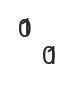

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import CDR3bVAE, PairedFVAE
from src.metrics import reconstruction_accuracy, VAELoss, PairedVAELoss
from src.datasets import CDR3BetaDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [4]:
df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
df.head()

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,...,TRBJ,partition,Unnamed: 0,allele,origin,original_index,TRBV_gene,TRBJ_gene,TRA_CDR3,TRB_CDR3
0,KALYS,LLKGGEQ,GTEIGGGTSYGKLT,MNHEY,SMNVEV,ASGTETQY,1,KLGGALQAK,KLGGALQAK,TRAV30*01,...,TRBJ2-5*01,2,32208.0,HLA-A*03:01,10x,2627.0,TRBV27,TRBJ2-5,CGTEIGGGTSYGKLTF,CASGTETQYF
1,DRGSQS,IYSNGD,AVNPANARLM,DFQATT,SNEGSKA,SARWGGGTDTQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,TRBJ2-3*01,3,37123.0,HLA-A*02:01,10x,3820.0,TRBV20-1,TRBJ2-3,CAVNPANARLMF,CSARWGGGTDTQYF
2,TSGFNG,NVLDGL,AVGDDKII,DFQATT,SNEGSKA,SARGLDRGTNEQY,1,AVFDRKSDAK,AVFDRKSDAK,TRAV1-2*01,...,TRBJ2-7*01,3,14961.0,HLA-A*11:01,10x,3592.0,TRBV20-1,TRBJ2-7,CAVGDDKIIF,CSARGLDRGTNEQYF
3,DRGSQS,IYSNGD,AVTPGTYKYI,LGHDT,YNNKEL,ASSPGTSIFVAEQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,TRBJ2-7*01,0,8197.0,HLA-A*02:01,10x,5933.0,TRBV3-1,TRBJ2-7,CAVTPGTYKYIF,CASSPGTSIFVAEQYF
4,TRDTTYY,RNSFDEQN,AFLYNQGGKLI,SGHDY,FNNNVP,ASSPGSRGNIQY,1,RAKFKQLL,RAKFKQLL,TRAV19*01,...,TRBJ2-4*01,1,23616.0,HLA-B*08:01,10x,2745.0,TRBV12-4,TRBJ2-4,CAFLYNQGGKLIF,CASSPGSRGNIQYF


In [5]:
df['TRB_CDR3'].apply(len).max(), df['TRA_CDR3'].apply(len).max(), df['peptide'].apply(len).max()

(25, 24, 12)

# paired model / datasets

In [141]:
from src.models import PairedFVAE
from src.datasets import PairedDataset
from torch.utils.data import SequentialSampler
sample = df.sample(3)
dataset = PairedDataset(sample, 23, 25, 12, pad_scale=-20, use_a=True, use_b=True, use_pep=True, cdr3b_col='TRB_CDR3', cdr3a_col='TRA_CDR3')
loader = dataset.get_dataloader(5, SequentialSampler)
model = PairedFVAE(max_len_b=23, max_len_a=25, max_len_pep=12, use_a=True, use_b=True, use_pep=True, use_v=False, use_j=False, hidden_dim=10, latent_dim=5)

In [142]:
# checking the slicing etc works
x_true = dataset.x
x_hat, mu, logvar = model(x_true)
seq_hat, v_hat, j_hat = model.reconstruct_hat(x_hat)
seq_true, v_true, j_true = model.reconstruct_hat(x_true)

In [145]:
seq_hat

tensor([[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16,  0, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16,  0, 16, 16, 16, 16],
        [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16,  0, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16,  0, 16, 16, 16, 16],
        [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16]])

In [117]:
from src.metrics import reconstruction_accuracy
reconstruction_accuracy(seq_true, seq_hat)

(0.082269087433815, 0, 0)

In [118]:
mask=(seq_true!=20).float()
true_lens=mask.sum(dim=1)
((seq_true==seq_hat).float() * mask)[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0.])

In [59]:
from src.data_processing import AA_KEYS
from random import randint

def apply_mutation(seq, n):
    seq = list(seq)  # Convert the sequence to a list of characters
    prev_idx = None
    idx = prev_idx
    for _ in range(n):
        while idx == prev_idx:
            idx = randint(0, len(seq) - 1)
        letter = seq[idx]
        while letter == seq[idx]:
            letter = AA_KEYS[randint(0, len(AA_KEYS) - 1)]
        seq[idx] = letter
        prev_idx = idx

    return ''.join(seq)  # Convert the list of characters back to a string

seq = 'CSASDNMVGAYEQYF'
mutated_seq = apply_mutation(seq, 3)
print(seq)
print(mutated_seq)


CSASDNMVGAYEQYF
CSAEDNMIGANEQYF


In [146]:

# Doing a fake dataset with small mutations and check the reconstruction accuracy
false_sample = sample.copy()
false_sample['TRB_CDR3'] = false_sample['TRB_CDR3'].apply(apply_mutation, n=6)
false_sample['TRA_CDR3'] = false_sample['TRA_CDR3'].apply(apply_mutation, n=7)
false_sample['peptide'] = false_sample['peptide'].apply(apply_mutation, n=2)
dataset = PairedDataset(sample, 23, 25, 12, pad_scale=-20, use_a=True, use_b=True, use_pep=True, cdr3b_col='TRB_CDR3', cdr3a_col='TRA_CDR3')
loader = dataset.get_dataloader(5, SequentialSampler)
false_dataset = PairedDataset(false_sample, 23, 25, 12, pad_scale=-20, use_a=True, use_b=True, use_pep=True, cdr3b_col='TRB_CDR3', cdr3a_col='TRA_CDR3')
x_true = dataset.x
x_hat = false_dataset.x

seq_hat, v_hat, j_hat = model.reconstruct_hat(x_hat)
seq_true, v_true, j_true = model.reconstruct_hat(x_true)
reconstruction_accuracy(seq_true, seq_hat)

(0.6213971972465515, 0, 0)

In [124]:
model = PairedFVAE(23,25,12,use_pep=True, use_v=False, use_j=False)
x_seq_recon, _, _ = model.slice_x(x_hat)
x_seq_true, _, _ = model.slice_x(x_true)


In [151]:
seq_hat.shape

torch.Size([3, 60])

In [196]:
from src.models import PairedFVAE
max_len_b=0
max_len_a=25
max_len_pep=12
use_b=False
use_a=True
use_pep=True
dataset = PairedDataset(sample, max_len_b, max_len_a, max_len_pep, pad_scale=-20, use_a=use_a, use_b=use_b, use_pep=use_pep, cdr3b_col='TRB_CDR3', cdr3a_col='TRA_CDR3')
loader = dataset.get_dataloader(len(sample), SequentialSampler)
x_true = dataset.x
model = PairedFVAE(max_len_b, max_len_a, max_len_pep, use_b=use_b, use_a=use_a, use_pep=use_pep)
seq_true, v_true, j_true = model.reconstruct_hat(x_true)
print(seq_true[:, :max_len_b].shape, seq_true[:, max_len_b:max_len_b+max_len_a], seq_true[:, max_len_b+max_len_a:])
results = predict_model(model, dataset, loader)

torch.Size([3, 0]) tensor([[ 4.,  9.,  1., 15.,  7.,  0.,  7., 15., 18.,  5., 10., 16., 13., 20.,
         20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.],
        [ 4.,  0., 19., 15.,  7.,  7., 18.,  5., 11., 19., 16., 13., 20., 20.,
         20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.],
        [ 4.,  0., 12., 15.,  7.,  6.,  7.,  7., 15.,  5.,  7.,  2., 10.,  9.,
         13., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.]]) tensor([[ 0., 19., 13.,  3.,  1., 11., 15.,  3.,  0., 11., 20., 20.],
        [ 6., 10.,  0.,  7.,  9.,  7.,  9., 10., 16., 19., 20., 20.],
        [ 7.,  9., 10.,  7., 13., 19., 13., 16., 10., 20., 20., 20.]])


In [206]:
model

CDR3bVAE(
  (encoder): Sequential(
    (0): Linear(in_features=511, out_features=255, bias=True)
    (1): SELU()
    (2): Linear(in_features=255, out_features=128, bias=True)
    (3): SELU()
  )
  (encoder_mu): Linear(in_features=128, out_features=32, bias=True)
  (encoder_logvar): Linear(in_features=128, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SELU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): SELU()
  )
  (decoder_sequence): Sequential(
    (0): Linear(in_features=128, out_features=255, bias=True)
    (1): SELU()
    (2): Linear(in_features=255, out_features=460, bias=True)
  )
  (decoder_v): Linear(in_features=128, out_features=51, bias=True)
)

In [213]:
from src.models import CDR3bVAE
from src.datasets import CDR3BetaDataset
max_len_b=23
dataset = CDR3BetaDataset(sample, max_len_b, use_v=True, use_j=False, pad_scale=-20,v_dim=51,cdr3b_col='TRB_CDR3')
loader = dataset.get_dataloader(len(sample), SequentialSampler)
x_true = dataset.x
model = CDR3bVAE(max_len_b, use_v=True, use_j=False, v_dim=51)
seq_true, v_true, j_true = model.reconstruct_hat(x_true)
results2 = predict_model(model, dataset, loader)

23


In [219]:
args = {}
args['cdr3a_col']='123'
args['cdr3b_col']='None'
args['use_a'] = not (args['cdr3a_col']=="None")
args['use_b'] = not (args['cdr3b_col']=="None")

In [222]:
ntm = {'x':0.125, 'b':.623, 'c':.2350}
np.sum([x for x in ntm.values()])

0.983

# Concat model

In [31]:
df['A2'].apply(len).max()

8

In [354]:
for c in ['A1', 'A2', 'A3', 'B1', 'B2', 'B3']:
    print(c, df[c].apply(len).max())

A1 7
A2 8
A3 22
B1 6
B2 7
B3 23


In [32]:
from src.data_processing import encode_batch

b3 = encode_batch(df['B3'], max_len=23, encoding='BL50LO', pad_scale=-20)
a3 = encode_batch(df['A3'], max_len=22, encoding='BL50LO', pad_scale=-20)
a2 = encode_batch(df['B2'], max_len=8, encoding='BL50LO', pad_scale=-20)
b2 = encode_batch(df['B2'], max_len=7, encoding='BL50LO', pad_scale=-20)

In [54]:
print('A1', df['A1'].apply(len).max())
print('A2', df['A2'].apply(len).max())
print('A3', df['A3'].apply(len).max())
print('B1', df['B1'].apply(len).max())
print('B2', df['B2'].apply(len).max())
print('B3', df['B3'].apply(len).max())

A1 7
A2 8
A3 22
B1 6
B2 7
B3 23


In [59]:
cat_first = torch.cat([b3, a3], dim=1).flatten(start_dim=1)
flat_first = torch.cat([b3.flatten(start_dim=1), a3.flatten(start_dim=1)], dim=1)
assert (cat_first==flat_first).all(), 'Wrong'

In [106]:
flat_first.view(-1, 23+22, 20)[0]

tensor([[  5.,  -2.,  -1.,  -2.,  -1.,  -1.,  -1.,   0.,  -2.,  -1.,  -2.,  -1.,
          -1.,  -3.,  -1.,   1.,   0.,  -3.,  -2.,   0.],
        [  1.,  -1.,   1.,   0.,  -1.,   0.,  -1.,   0.,  -1.,  -3.,  -3.,   0.,
          -2.,  -3.,  -1.,   5.,   2.,  -4.,  -2.,  -2.],
        [  0.,  -3.,   0.,  -1.,  -3.,  -2.,  -3.,   8.,  -2.,  -4.,  -4.,  -2.,
          -3.,  -4.,  -2.,   0.,  -2.,  -3.,  -3.,  -4.],
        [  0.,  -1.,   0.,  -1.,  -1.,  -1.,  -1.,  -2.,  -2.,  -1.,  -1.,  -1.,
          -1.,  -2.,  -1.,   2.,   5.,  -3.,  -2.,   0.],
        [ -1.,   0.,   0.,   2.,  -3.,   2.,   6.,  -3.,   0.,  -4.,  -3.,   1.,
          -2.,  -3.,  -1.,  -1.,  -1.,  -3.,  -2.,  -3.],
        [  0.,  -1.,   0.,  -1.,  -1.,  -1.,  -1.,  -2.,  -2.,  -1.,  -1.,  -1.,
          -1.,  -2.,  -1.,   2.,   5.,  -3.,  -2.,   0.],
        [ -1.,   1.,   0.,   0.,  -3.,   7.,   2.,  -2.,   1.,  -3.,  -2.,   2.,
           0.,  -4.,  -1.,   0.,  -1.,  -1.,  -1.,  -3.],
        [ -2.,  -1.,  -2., 

In [57]:
from src.models import CDR3bVAE, FullTCRVAE
model = CDR3bVAE(max_len = 23+22, pad_scale=-20, use_v=False, use_j=False)
seq_hat, _, _ = model.reconstruct_hat(flat_first)
seq, v, j = model.slice_x(flat_first)
(seq_hat != 20).float()

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

In [42]:
max_len_a1=0
max_len_a2=0
max_len_a3=0
max_len_b1=0
max_len_b2=0
max_len_b3=0

assert not all([x==0 for x in [max_len_a1, max_len_a2, max_len_a3, max_len_b1, max_len_b2, max_len_b3]]), 'xd'

AssertionError: xd

In [68]:
from src.models import FullTCRVAE
from src.datasets import FullTCRDataset
from torch.utils.data import SequentialSampler
fulltcr_dataset = FullTCRDataset(df, 7, 8, 22, 6, 7, 23, pad_scale=-20)
fulltcr_loader = fulltcr_dataset.get_dataloader(1024, SequentialSampler)
fulltcr_model = FullTCRVAE()

In [74]:
fulltcr_model.to(torch.device('cuda:0'))

AssertionError: Torch not compiled with CUDA enabled

# Latent dim control (additional loss)

In [98]:
x_subset = fulltcr_dataset.x[fulltcr_dataset.df.query('peptide=="GILGFVFTL"').index]
z = fulltcr_model.embed(x_subset)

In [101]:
for i, x in enumerate(fulltcr_loader):
    print(i, x)
    break

0 tensor([[ -1.,   3.,   0.,  ..., -20., -20., -20.],
        [ -2.,  -2.,   2.,  ..., -20., -20., -20.],
        [  0.,  -1.,   0.,  ..., -20., -20., -20.],
        ...,
        [ -2.,  -2.,   2.,  ..., -20., -20., -20.],
        [ -1.,  -1.,   7.,  ..., -20., -20., -20.],
        [ -2.,  -2.,   2.,  ..., -20., -20., -20.]])


In [100]:
z.mean(dim=0)

[autoreload of src.metrics failed: Traceback (most recent call last):
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/riwa/Documents/code/tclustr/src/metrics.py", line 235, in <module>
    class TripleVAELoss(VAELoss):
  File "/Users/riwa/Documents/code/tclustr/src/metrics.py", line 236, in TripleVAELoss
    raise NotImp

tensor([-2.2331,  0.6798,  1.2645, -0.2473,  0.6084,  0.1823,  0.2082, -0.1631,
         1.5483, -0.1914, -1.3046, -1.0642,  0.3633, -0.0941,  0.5933,  1.8078,
        -1.2973,  2.1205,  1.6201, -2.5718,  1.4542, -0.2927,  0.6241,  0.9395,
         0.8390, -0.0289, -0.1067, -3.6086,  0.5269, -0.7022,  1.0120, -0.4022,
        -0.3717, -2.2359,  0.7792, -0.8685, -1.0450, -1.5682, -1.7087, -1.0641,
        -0.2204, -0.3764, -1.0976,  0.7779, -0.9610,  0.4613,  0.2907,  0.2122,
        -0.4083,  0.1400,  1.3919,  0.4340, -1.6895, -0.7093,  0.7120,  2.0495,
         1.7948, -0.3105, -0.3771,  0.9735,  1.2006, -0.4415,  0.0934, -0.2468],
       grad_fn=<MeanBackward1>)

# vmap tests

In [313]:
# Tentative pepmap that should be saved forever
PEPMAP = {k:i for i,k in enumerate(sorted(df.peptide.unique()))}


In [316]:
from src.datasets import VAEDataset
from torch.utils.data import RandomSampler
import numpy as np

def get_same_spec_idx(row, df):
    current_idx = row.name
    pep = row['peptide']
    return [x for x in df.query('peptide==@pep').index if x != current_idx]


def pad_and_stack(list_of_lists, padding_value=-1):
    # Determine the maximum length
    max_length = max(len(sublist) for sublist in list_of_lists)

    # Create a NumPy array filled with the padding value
    padded_lists = np.full((len(list_of_lists), max_length), padding_value)

    # Copy each sub-list into the padded array
    for i, sublist in enumerate(list_of_lists):
        padded_lists[i, :len(sublist)] = sublist

    return torch.from_numpy(padded_lists)
    
class TEST(VAEDataset):

    def __init__(self,
                 df, max_len_a1, max_len_a2, max_len_a3, max_len_b1, max_len_b2, max_len_b3,
                 encoding='BL50LO', pad_scale=None,
                 a1_col='A1', a2_col='A2', a3_col='A3', b1_col='B1', b2_col='B2', b3_col='B3'):
        super(TEST, self).__init__()
        # TODO : Current behaviour If max_len_x = 0, then don't use that chain...
        #        Is that the most elegant way to do this ?
        assert not all([x == 0 for x in [max_len_a1, max_len_a2, max_len_a3,
                                         max_len_b1, max_len_b2, max_len_b3]]), \
            'All loops max_len are 0! No chains will be added'

        x_seq = []
        self.max_len_a1 = max_len_a1
        self.max_len_a2 = max_len_a2
        self.max_len_a3 = max_len_a3
        self.max_len_b1 = max_len_b1
        self.max_len_b2 = max_len_b2
        self.max_len_b3 = max_len_b3
        self.use_a1 = not (max_len_a1 == 0)
        self.use_a2 = not (max_len_a2 == 0)
        self.use_a3 = not (max_len_a3 == 0)
        self.use_b1 = not (max_len_b1 == 0)
        self.use_b2 = not (max_len_b2 == 0)
        self.use_b3 = not (max_len_b3 == 0)

        # bad double loop because brain slow
        for max_len, seq_col in zip([max_len_a1, max_len_a2, max_len_a3, max_len_b1, max_len_b2, max_len_b3],
                                    [a1_col, a2_col, a3_col, b1_col, b2_col, b3_col]):
            if max_len != 0:
                df['len_q'] = df[seq_col].apply(len)
                df = df.query('len_q <= @max_len')
        for max_len, seq_col in zip([max_len_a1, max_len_a2, max_len_a3, max_len_b1, max_len_b2, max_len_b3],
                                    [a1_col, a2_col, a3_col, b1_col, b2_col, b3_col]):
            if max_len != 0:
                x_seq.append(encode_batch(df[seq_col], max_len, encoding, pad_scale).flatten(start_dim=1))

        self.df = df.drop(columns=['len_q']).reset_index(drop=True)
        self.x = torch.cat(x_seq, dim=1)
        idx_list = df.apply(get_same_spec_idx, df=df, axis=1).to_list()
        self.idx_tensor = pad_and_stack(idx_list, padding_value=-1)
        self.labels = torch.from_numpy(df['peptide'].map(PEPMAP).values)
        
    def __getitem__(self, idx):
        return self.x[idx], self.idx_tensor[idx], self.labels[idx]
    

In [359]:
# Saving PEPMAP to be re-used
pkl_dump(PEPMAP, '../data/Matrices/231031_nettcr_pep_map.pkl')

/Users/riwa/Documents/code/tclustr/data/Matrices/231031_nettcr_pep_map.pkl saved.


[autoreload of src.datasets failed: Traceback (most recent call last):
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/riwa/Documents/code/tclustr/src/datasets.py", line 5, in <module>
    from src.data_processing import encode_batch, V_MAP, J_MAP, PEP_MAP
ImportError: cannot import name 'PEP_MAP' from 'src.data_processi

In [317]:
from src.models import FullTCRVAE
model = FullTCRVAE(7,8,22,6,7,23)

In [318]:
dataset = TEST(df, 7,8,22,6,7,23,pad_scale=-20)

## Use global idx for entire dataset?

In [336]:
torch.manual_seed(27093)
loader = dataset.get_dataloader(256, RandomSampler)
for x, idx, labels in loader:
    print(x.shape, idx.shape)
    break

torch.Size([256, 1460]) torch.Size([256, 1124])


Reasoning : Here, we take a single index, figure out what to do to get the similar Z latent tensor for a given item, then use torch.vmap to apply it to all the items in a batch

In [337]:
# For a single item, unpad the index tensor in order to get all the idxs that are with the same specificity as the given item (here item is idx==0)
unpadded = idx[0][idx[0]!=-1]
pad_len = len(idx[0][idx[0]==-1])
# This here takes the unpadded index tensor to index the dataset, then take the first item (x) using [0]
similar = loader.dataset[unpadded][0]
# here, the given item we indexed had 933 similar Xs
print(similar.shape, similar)
model.eval()
z_item = model.embed(x[0:1])
z_batch = model.embed(x)
z_similar = model.embed(similar)
print(z_similar.shape, z_similar)

torch.Size([715, 1460]) tensor([[  0.,  -1.,   0.,  ..., -20., -20., -20.],
        [  5.,  -2.,  -1.,  ..., -20., -20., -20.],
        [  1.,  -1.,   1.,  ..., -20., -20., -20.],
        ...,
        [  0.,  -1.,   0.,  ..., -20., -20., -20.],
        [  0.,  -1.,   0.,  ..., -20., -20., -20.],
        [  0.,  -1.,   0.,  ..., -20., -20., -20.]])
torch.Size([715, 64]) tensor([[ 0.9176,  0.1794,  0.9044,  ..., -0.7415,  1.0966,  0.8663],
        [ 1.2953,  0.5653,  1.2924,  ..., -0.1195,  1.1858,  1.5396],
        [ 1.9437,  0.1443,  0.0648,  ..., -0.9411,  2.1519,  0.5631],
        ...,
        [ 2.1478,  0.8220,  0.1268,  ..., -0.1212,  1.7150,  1.5651],
        [ 1.9482,  1.3227, -0.3979,  ..., -0.7113,  1.5373,  1.9503],
        [ 1.5420,  0.1140,  0.4547,  ..., -0.0208,  1.4899,  0.8553]],
       grad_fn=<AddmmBackward0>)


In [338]:
model.eval()
z_all = model.embed(dataset.x)

## Use batched pairwise distances and triplet loss ?

In [387]:
from torch.nn import CosineSimilarity, CosineEmbeddingLoss

In [396]:
cos_loss = CosineEmbeddingLoss()

cos_loss(z_batch, z_batch[::], labels)

tensor(0., grad_fn=<MeanBackward0>)

In [437]:
import torch

def compute_cosine_distance(embedding_matrix, *args, **kwargs):
    # Compute the dot product of the embedding matrix
    dot_product = torch.mm(embedding_matrix, embedding_matrix.t())
    
    # Compute the L2 norms of the vectors
    norms = torch.norm(embedding_matrix, p=2, dim=1, keepdim=True)
    
    # Compute the pairwise cosine distances
    cosine_distance_matrix = 1 - dot_product / (norms * norms.t())
    
    return cosine_distance_matrix

cosine_distance_matrix = compute_cosine_distance(z_batch)


In [445]:
from src.metrics import CombinedVAELoss
criterion = CombinedVAELoss(weight_kld = 0.05, weight_seq=3, weight_vae=1, weight_triplet=1)

0.9836065573770493 0.0 0.0 0.01639344262295082


In [547]:
from src.metrics import TripletLoss

triplet = TripletLoss(dist_type='cosine', margin=0.05)
triplet(z_batch, labels)

tensor(0.0178, grad_fn=<MeanBackward0>)

In [540]:
criterion(x_hat, x, mu, logvar, z_batch, labels)

(tensor(71.1716, grad_fn=<DivBackward0>),
 tensor(0.0012, grad_fn=<DivBackward0>),
 tensor(0.0067, grad_fn=<DivBackward0>))

In [429]:
test = compute_cosine_distance
test(z_batch, z_batch)

tensor([[-1.1921e-07,  8.8525e-02,  1.4484e-01,  ...,  1.6952e-01,
          1.1687e-01,  1.4104e-01],
        [ 8.8525e-02, -1.1921e-07,  8.8099e-02,  ...,  1.6081e-01,
          1.4339e-01,  1.6584e-01],
        [ 1.4484e-01,  8.8099e-02, -1.1921e-07,  ...,  1.7315e-01,
          9.2561e-02,  1.3772e-01],
        ...,
        [ 1.6952e-01,  1.6081e-01,  1.7315e-01,  ..., -2.3842e-07,
          1.5152e-01,  2.1792e-01],
        [ 1.1687e-01,  1.4339e-01,  9.2561e-02,  ...,  1.5152e-01,
         -1.1921e-07,  5.8871e-02],
        [ 1.4104e-01,  1.6584e-01,  1.3772e-01,  ...,  2.1792e-01,
          5.8871e-02,  0.0000e+00]], grad_fn=<RsubBackward1>)

In [438]:
dist_type = 'cosine'
p = 1 if dist_type=='l1' else 2 if dist_type=='l2' else None
compute_cosine_distance(z_batch, z_batch, p=p)

tensor([[-1.1921e-07,  8.8525e-02,  1.4484e-01,  ...,  1.6952e-01,
          1.1687e-01,  1.4104e-01],
        [ 8.8525e-02, -1.1921e-07,  8.8099e-02,  ...,  1.6081e-01,
          1.4339e-01,  1.6584e-01],
        [ 1.4484e-01,  8.8099e-02, -1.1921e-07,  ...,  1.7315e-01,
          9.2561e-02,  1.3772e-01],
        ...,
        [ 1.6952e-01,  1.6081e-01,  1.7315e-01,  ..., -2.3842e-07,
          1.5152e-01,  2.1792e-01],
        [ 1.1687e-01,  1.4339e-01,  9.2561e-02,  ...,  1.5152e-01,
         -1.1921e-07,  5.8871e-02],
        [ 1.4104e-01,  1.6584e-01,  1.3772e-01,  ...,  2.1792e-01,
          5.8871e-02,  0.0000e+00]], grad_fn=<RsubBackward1>)

In [548]:
up_with

NameError: name 'up_with' is not defined

In [424]:
cosine_distance_matrix[0]

tensor([-1.1921e-07,  8.8525e-02,  1.4484e-01,  8.6070e-02,  1.2365e-01,
         9.4377e-02,  9.2447e-02,  1.4498e-01,  2.0667e-01,  4.1107e-02,
         4.9342e-02,  1.1338e-01,  1.3825e-01,  1.3562e-01,  5.9261e-02,
         9.1015e-02,  3.9438e-02,  1.1745e-01,  1.3014e-01,  9.0559e-02,
         1.0822e-01,  1.1863e-01,  1.2915e-01,  2.6091e-01,  7.9152e-02,
         1.0801e-01,  1.1053e-01,  9.7344e-02,  6.5381e-02,  1.4941e-01,
         1.2490e-01,  1.4857e-01,  1.3122e-01,  7.7253e-02,  1.2720e-01,
         1.6437e-01,  1.1458e-01,  5.6446e-02,  5.6843e-02,  8.4044e-02,
         4.2943e-02,  8.2702e-02,  4.8154e-02,  1.0479e-01,  1.0309e-01,
         1.6739e-01,  1.2356e-01,  1.0505e-01,  9.3499e-02,  7.8227e-02,
         1.4517e-01,  1.2957e-01,  1.6339e-01,  4.3252e-02,  5.3720e-02,
         7.2856e-02,  1.0537e-01,  5.4271e-02,  1.4579e-01,  1.3248e-01,
         1.0790e-01,  1.2080e-01,  3.8989e-02,  1.0927e-01,  7.8304e-02,
         1.0553e-01,  7.9875e-02,  1.2455e-01,  1.2

In [426]:
cos = CosineSimilarity()
1-cos(z_batch[0], z_batch)

tensor([-1.1921e-07,  8.8525e-02,  1.4483e-01,  8.6070e-02,  1.2365e-01,
         9.4377e-02,  9.2446e-02,  1.4498e-01,  2.0667e-01,  4.1106e-02,
         4.9342e-02,  1.1338e-01,  1.3825e-01,  1.3562e-01,  5.9261e-02,
         9.1015e-02,  3.9438e-02,  1.1745e-01,  1.3014e-01,  9.0559e-02,
         1.0822e-01,  1.1863e-01,  1.2915e-01,  2.6091e-01,  7.9152e-02,
         1.0801e-01,  1.1053e-01,  9.7343e-02,  6.5381e-02,  1.4941e-01,
         1.2490e-01,  1.4857e-01,  1.3122e-01,  7.7253e-02,  1.2720e-01,
         1.6437e-01,  1.1458e-01,  5.6446e-02,  5.6843e-02,  8.4044e-02,
         4.2943e-02,  8.2703e-02,  4.8154e-02,  1.0479e-01,  1.0309e-01,
         1.6739e-01,  1.2356e-01,  1.0505e-01,  9.3498e-02,  7.8227e-02,
         1.4517e-01,  1.2957e-01,  1.6339e-01,  4.3252e-02,  5.3720e-02,
         7.2857e-02,  1.0537e-01,  5.4271e-02,  1.4579e-01,  1.3248e-01,
         1.0790e-01,  1.2080e-01,  3.8989e-02,  1.0927e-01,  7.8304e-02,
         1.0553e-01,  7.9875e-02,  1.2455e-01,  1.2

In [413]:
pairwise_distances1 = torch.cdist(z_batch, z_batch)
pairwise_distances2 = torch.nn.functional.pairwise_distance(z_batch[0], z_batch)


In [416]:
pairwise_distances1[0]

tensor([0.0000, 5.1177, 6.7114, 5.1391, 6.1053, 5.4939, 5.1972, 6.6448, 7.5363,
        3.5968, 4.2440, 5.9266, 6.4634, 6.3715, 4.2044, 5.3600, 3.4410, 5.8228,
        6.1673, 5.3943, 5.6196, 6.0244, 6.1504, 8.3342, 4.8248, 5.6472, 5.6581,
        5.3302, 4.5688, 6.7650, 6.2608, 6.6244, 6.2698, 4.8138, 6.2009, 6.8383,
        6.3650, 4.2736, 4.1638, 5.1422, 3.6609, 5.0608, 3.9235, 5.5264, 5.4719,
        6.9015, 6.1706, 5.5241, 5.4852, 4.8182, 6.6400, 6.5492, 6.7787, 3.6688,
        4.2372, 4.6404, 5.5282, 4.0215, 6.5536, 6.2898, 5.6694, 5.9250, 3.4652,
        5.7096, 4.8583, 5.6490, 5.2844, 6.0828, 6.1250, 6.4515, 6.7158, 5.4626,
        6.8416, 5.9888, 6.6957, 6.4350, 6.0354, 5.1977, 4.0061, 6.6097, 4.6880,
        6.2462, 6.0792, 5.6378, 5.1446, 5.4127, 6.1163, 5.6377, 6.1255, 5.2098,
        5.3811, 5.8612, 4.6756, 6.5816, 7.0530, 4.0043, 5.5882, 5.7639, 5.8755,
        6.8871, 4.8207, 3.6901, 6.2548, 5.0299, 5.5976, 6.5596, 5.0891, 4.9015,
        6.4481, 6.1801, 6.0944, 6.0346, 

In [415]:
pairwise_distances1.shape

torch.Size([256, 256])

In [339]:
# Here, pairwise distances can be whatever.
pairwise_distances1 = torch.cdist(z_batch, z_batch)

# these below are the parts that matter for the implementation
mask_positive = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1)).float()
mask_negative = 1 - mask_positive

margin = 1.0
# Compute the positive and negative distances
positive_distances = mask_positive * pairwise_distances
negative_distances = mask_negative * pairwise_distances

# Calculate the triplet loss
loss = torch.relu(positive_distances - negative_distances + margin)
loss = loss.mean()
return loss

In [358]:
from src.metrics import CombinedVAELoss
criterion = CombinedVAELoss()
criterion.__class__.__name__ == 'CombinedVAELoss'

0.75 0.0 0.0 0.25


True

In [353]:
pairwise_distances1 * mask_negative

tensor([[0.0000, 5.1177, 6.7114,  ..., 6.9833, 5.8539, 6.4508],
        [5.1177, 0.0000, 5.1668,  ..., 6.4702, 6.2941, 6.8121],
        [6.7114, 5.1668, 0.0000,  ..., 7.1702, 5.2849, 0.0000],
        ...,
        [6.9833, 6.4702, 7.1702,  ..., 0.0000, 6.2330, 7.3809],
        [5.8539, 6.2941, 5.2849,  ..., 6.2330, 0.0000, 4.0400],
        [6.4508, 6.8121, 0.0000,  ..., 7.3809, 4.0400, 0.0000]],
       grad_fn=<MulBackward0>)

In [352]:
pairwise_distances1 * mask_positive

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 6.4403],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 6.4403,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)

In [349]:
z_batch

tensor([[ 1.1138,  0.6592,  1.0491,  ..., -0.6828,  1.6321,  2.7155],
        [ 0.4566,  0.2783,  0.6465,  ..., -0.4741,  1.1475,  2.5910],
        [ 1.2872,  0.4077,  0.7408,  ..., -0.4852,  1.6835,  1.5436],
        ...,
        [ 1.0215,  1.4980,  0.0328,  ..., -0.4786,  0.8880,  1.2802],
        [ 2.0577,  0.7814,  0.2786,  ..., -0.2874,  1.6500,  0.9614],
        [ 2.1224,  0.3473,  0.1631,  ..., -0.9703,  1.3913,  0.5789]],
       grad_fn=<AddmmBackward0>)

In [373]:
from src.datasets import TCRSpecificDataset

dataset = TCRSpecificDataset(df, 7,8,22,6,7,23, pad_scale=-20)
loader = dataset.get_dataloader(256, RandomSampler)

In [374]:
for x in loader:
    break

In [375]:
x, labels = x.pop(0), x.pop(-1)

In [376]:
x.shape, labels.shape

(torch.Size([256, 1460]), torch.Size([256]))

In [377]:
hasattr(criterion, 'triplet_loss')

True

In [380]:
x_hat, mu, logvar = model(x)
z = model.embed(x)

In [382]:
recon, kld, tripl = criterion(x_hat, x, mu, logvar, z, labels)

# testing other arc

In [565]:
z_batch[::-1, :]

ValueError: step must be greater than zero

In [562]:
num_hidden = [200]
num_latent = 20
# Initialize lists for holding hidden layers
encoderlayers = nn.ModuleList()
encodernorms = nn.ModuleList()
decoderlayers = nn.ModuleList()
decodernorms = nn.ModuleList()
# Input dims
input_size=100
### Layers
# Hidden layers
for nin, nout in zip([input_size] + num_hidden, num_hidden):
    encoderlayers.append(nn.Linear(nin, nout))
    encodernorms.append(nn.BatchNorm1d(nout))

# Latent layers
mu = nn.Linear(num_hidden[-1], num_latent)  # mu layer
var = nn.Linear(num_hidden[-1], num_latent)  # logvariance layer

# Decoding layers
for nin, nout in zip(
    [num_latent] + num_hidden[::-1], num_hidden[::-1]
):
    decoderlayers.append(nn.Linear(nin, nout))
    decodernorms.append(nn.BatchNorm1d(nout))

# Reconstruction - output layers
out = nn.Linear(num_hidden[0], input_size)  # to output

In [564]:
z_batch.device

device(type='cpu')

In [563]:
encoderlayers, mu, var, decoderlayers, out

(ModuleList(
   (0): Linear(in_features=100, out_features=200, bias=True)
 ),
 Linear(in_features=200, out_features=20, bias=True),
 Linear(in_features=200, out_features=20, bias=True),
 ModuleList(
   (0): Linear(in_features=20, out_features=200, bias=True)
 ),
 Linear(in_features=200, out_features=100, bias=True))

In [559]:
def encode(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Encodes the data in the data loader and returns the encoded matrix.

        Args:
            x: input data

        Returns:
            A tuple containing:
                mean latent vector
                log-variance latent vector
        """
        # Hidden layers
        for encoderlayer, encodernorm in zip(self.encoderlayers, self.encodernorms):
            x = encoderlayer(x)
            x = self.relu(x)
            x = self.dropoutlayer(x)
            x = encodernorm(x)

        return self.mu(x), self.var(x)
def decode(
        self, x: torch.Tensor
    ) -> tuple[Optional[list[torch.Tensor]], Optional[torch.Tensor]]:
        """
        Decode to the input space from the latent space

        Args:
            x: sample from latent space distribution

        Returns:
            A tuple containing:
                cat_out:
                    list of reconstructions of every categorical data class
                con_out:
                    reconstruction of continuous data
        """
        for decoderlayer, decodernorm in zip(self.decoderlayers, self.decodernorms):
            x = decoderlayer(x)
            x = self.relu(x)
            x = self.dropoutlayer(x)
            x = decodernorm(x)

        reconstruction = self.out(x)

        # Decompose reconstruction to categorical and continuous variables
        # if both types are in the input
        cat_out, con_out = None, None
        if self.num_categorical > 0:
            cat_out = self.decompose_categorical(reconstruction)
        if self.num_continuous > 0:
            con_out = reconstruction.narrow(
                1, self.num_categorical, self.num_continuous
            )

        return cat_out, con_out

def forward(
        self, tensor: torch.Tensor
    ) -> tuple[list[torch.Tensor], torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward propagate through the VAE network

        Args:
            tensor (torch.Tensor): input data

        Returns:
            (tuple): a tuple containing:
                cat_out (list): list of reconstructions of every categorical
                    data class
                con_out (torch.Tensor): reconstructions of continuous data
                mu (torch.Tensor): mean latent vector
                logvar (torch.Tensor): mean log-variance vector
        """
        mu, logvar = self.encode(tensor)
        z = self.reparameterize(mu, logvar)
        cat_out, con_out = self.decode(z)

        return cat_out, con_out, mu, logvar

ModuleList(
  (0): Linear(in_features=100, out_features=200, bias=True)
  (1): Linear(in_features=200, out_features=200, bias=True)
)